<a href="https://colab.research.google.com/github/noahnguyen2004/Loan-Default-Prediction/blob/main/loan_lending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
!pip install scikit-plot

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from scikitplot.metrics import plot_roc_curve

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [44]:
df = pd.read_csv('/content/drive/MyDrive/loan default/loan_lending_club.csv', encoding = 'latin-1',
                 usecols=['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
                            'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti',
                            'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                            'mort_acc', 'pub_rec_bankruptcies'])
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,credit_card,Computer,27.65,Jan-1985,3.00,0.00,13648.00,83.7%,9.00,f,Individual,NaN,0.00
1,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,car,bike,1.00,Apr-1999,3.00,0.00,1687.00,9.4%,4.00,f,Individual,NaN,0.00
2,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,small_business,real estate business,8.72,Nov-2001,2.00,0.00,2956.00,98.5%,10.00,f,Individual,NaN,0.00
3,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,other,personel,20.00,Feb-1996,10.00,0.00,5598.00,21%,37.00,f,Individual,NaN,0.00
4,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Fully Paid,other,Personal,17.94,Jan-1996,15.00,0.00,27783.00,53.9%,38.00,f,Individual,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925489,10000.00,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,Apr-2017,Fully Paid,debt_consolidation,Debt consolidation,19.55,Sep-1993,15.00,0.00,9751.00,15.7%,27.00,w,Individual,0.00,0.00
2925490,10050.00,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,20.56,May-1993,15.00,0.00,14300.00,47%,21.00,w,Individual,0.00,0.00
2925491,6000.00,36 months,11.44%,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,Apr-2017,Fully Paid,credit_card,Credit card refinancing,19.99,May-1990,9.00,0.00,1356.00,10.1%,18.00,w,Individual,0.00,0.00
2925492,30000.00,60 months,25.49%,889.18,E,E4,Assistant Manager,4 years,MORTGAGE,105700.00,Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,27.26,Nov-1997,12.00,0.00,15252.00,72.6%,23.00,w,Individual,3.00,0.00


# Exploratory Data Analysis (EDA)

In [45]:
loan_status_counts = df['loan_status'].value_counts()

loan_status_df = pd.DataFrame({
    'Loan Status': loan_status_counts.index,
    'Counts': loan_status_counts.values
})

loan_status_df

,Loan Status,Counts
0,Fully Paid,1497783
1,Current,1031016
2,Charged Off,362548
3,Late (31-120 days),16154
4,In Grace Period,10028
5,Late (16-30 days),2719
6,Issued,2062
7,Does not meet the credit policy. Status:Fully ...,1988
8,Does not meet the credit policy. Status:Charge...,761
9,Default,433


The goal of this project is to predict whether a borrower can pay off the installments or not, so only Fully Paid and Charged Off are taken into account.
- Charged Off: the borrower has become delinquent for a period of time and the company did not believe the borrower can pay back the loan amount, but the borrower still has the responsibility to do so.

In [46]:
# retain binary class (Fully Paid, Charged Off) for loan_status as target, and drop the rest
df.drop(df[df['loan_status'] == 'Late (31-120 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'In Grace Period'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Current'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Late (16-30 days)'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Issued'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'].index, inplace = True)
df.drop(df[df['loan_status'] == 'Default'].index, inplace = True)

df = df.reset_index(drop=True)
df

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies
0,5000.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.00,Verified,Dec-2011,Fully Paid,credit_card,Computer,27.65,Jan-1985,3.00,0.00,13648.00,83.7%,9.00,f,Individual,NaN,0.00
1,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.00,Source Verified,Dec-2011,Charged Off,car,bike,1.00,Apr-1999,3.00,0.00,1687.00,9.4%,4.00,f,Individual,NaN,0.00
2,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.00,Not Verified,Dec-2011,Fully Paid,small_business,real estate business,8.72,Nov-2001,2.00,0.00,2956.00,98.5%,10.00,f,Individual,NaN,0.00
3,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.00,Source Verified,Dec-2011,Fully Paid,other,personel,20.00,Feb-1996,10.00,0.00,5598.00,21%,37.00,f,Individual,NaN,0.00
4,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.00,Source Verified,Dec-2011,Fully Paid,other,Personal,17.94,Jan-1996,15.00,0.00,27783.00,53.9%,38.00,f,Individual,NaN,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860328,10000.00,36 months,7.99%,313.32,A,A5,Rn,10+ years,MORTGAGE,65000.00,Source Verified,Apr-2017,Fully Paid,debt_consolidation,Debt consolidation,19.55,Sep-1993,15.00,0.00,9751.00,15.7%,27.00,w,Individual,0.00,0.00
1860329,10050.00,36 months,16.99%,358.26,D,D1,Sales Associate,8 years,RENT,37000.00,Not Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,20.56,May-1993,15.00,0.00,14300.00,47%,21.00,w,Individual,0.00,0.00
1860330,6000.00,36 months,11.44%,197.69,B,B4,Contact input,5 years,RENT,41000.00,Source Verified,Apr-2017,Fully Paid,credit_card,Credit card refinancing,19.99,May-1990,9.00,0.00,1356.00,10.1%,18.00,w,Individual,0.00,0.00
1860331,30000.00,60 months,25.49%,889.18,E,E4,Assistant Manager,4 years,MORTGAGE,105700.00,Verified,Apr-2017,Charged Off,debt_consolidation,Debt consolidation,27.26,Nov-1997,12.00,0.00,15252.00,72.6%,23.00,w,Individual,3.00,0.00


## Appropriate data type of each feature
- loan_amnt: numerical -> float
- term: categorical -> string
- int_rate: numerical -> float
- installment: numerical -> float
- grade: categorical -> string
- sub_grade: categorical -> string
- emp_title: categorical -> string
- emp_length: categorical -> string
- home_ownership: categorical -> string
- annual_inc: numerical -> float
- verification_status: categorical -> string
- issue_d: categorical -> string
- loan_status: categorical (target) -> string
- purpose: categorical -> string
- title: categorical -> string
- dti: numerical -> float
- earliest_cr_line: categorical -> string
- open_acc: numerical -> float
- pub_rec: categorical -> int
- revol_bal: numerical -> float
- revol_util: numerical -> float
- total_acc: numerical -> float
- initial_list_status: categorical -> string
- application_type: categorical -> string
- mort_acc: numerical -> int
- pub_rec_bankruptcies: numerical -> int

### We notice some issues:
- **Inappropriate data types:** the values in the `int_rate` column contain % sign, which does not represent float data type. We would drop the % sign and convert `int_rate` values into float. The same with `revol_util`.
- **Date and time:** there are a lot of different dates in the dataset, so we would want to visualize date and time in the form of YYYY only.
- **Missing values:** typical problem occurred in tabular data. We should address the meaning of these missing values in each column before deciding to drop or keep.
- **Excessive values in columns:** the `emp_title` column, for example, contains a lot of different employment titles. We don't really need all of them, so we would take the top 2x titles that are most likely to afford a loan.


## Dealing with inappropriate data types

In [47]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)      # drop % sign in values of int_rate and convert into float
df['revol_util'] = df['revol_util'].str.replace('%', '').astype(float)  # drop % sign in values of revol_util and convert into float

In [48]:
df['issue_d'] = pd.to_datetime(df['issue_d'])                           # convert into YYYY-MM-DD data type
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])         # convert into YYYY-MM-DD data type

## Dealing with excessive values in each feature

### `emp_title` and `emp_length`
As `emp_title` and `emp_length` contain too many null (NaN) values, they can badly affect the model performance later, specifically bias, or high variance if we try to fill in with mean, median, or other types of data. We would be tempted to drop those columns. However, `emp_title` and `emp_length` may contribute to the ability in paying off installments as an employment title may show how stable it is to be approved for a loan. The same goes for employment length.

- for `emp_title`, consider the top 20 titles that are most likely able to afford loans.

In [ ]:
df['emp_length'].value_counts()

In [ ]:
df['emp_title'].value_counts()[:20]       # top 20 employment titles with most loan borrowed

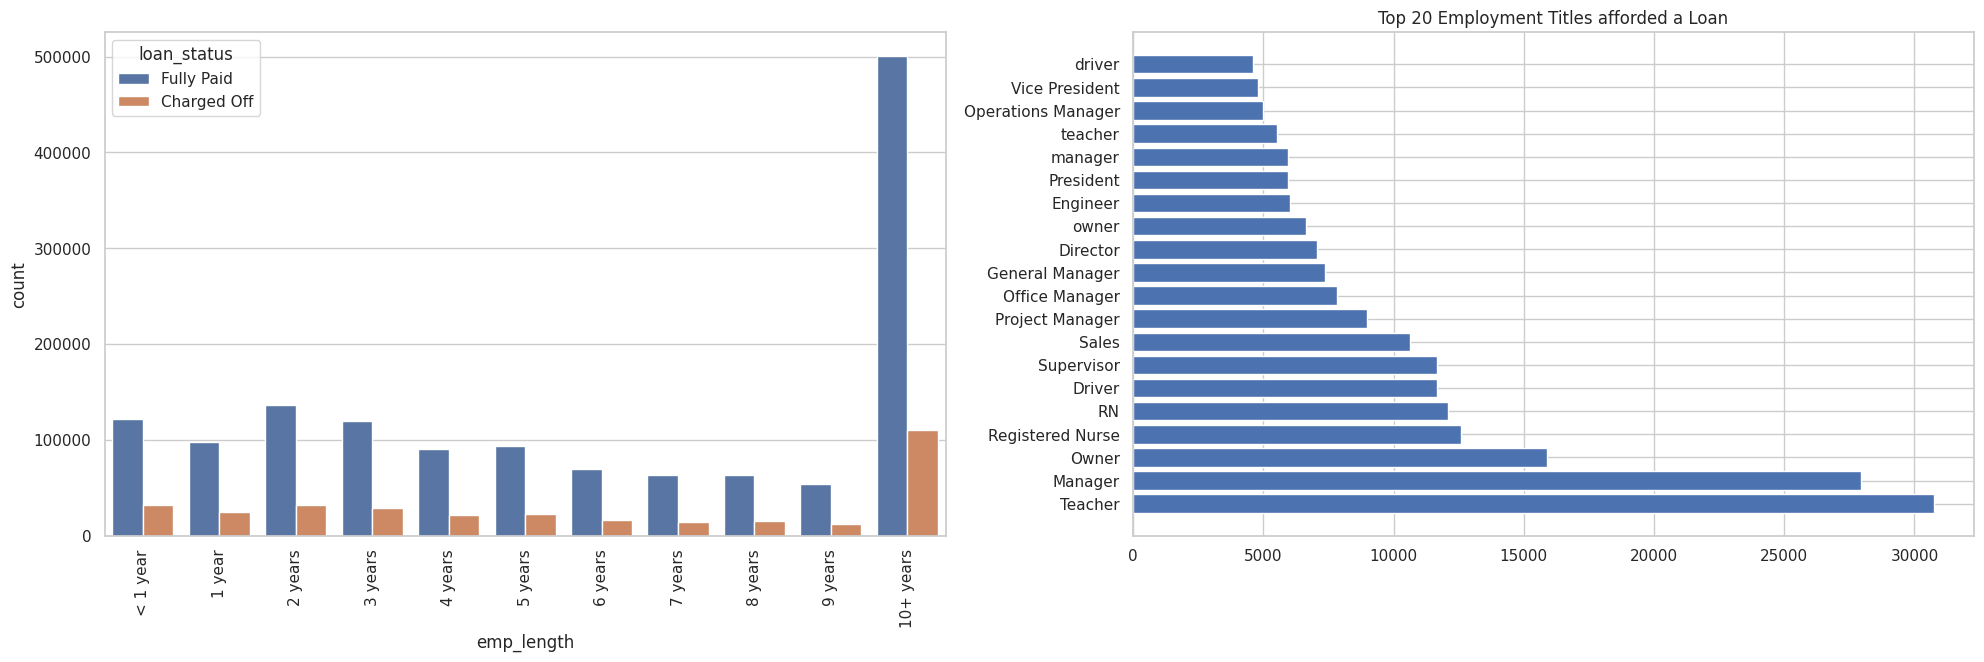

In [51]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
g = sns.countplot(data=df, x='emp_length', hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(2, 2, 2)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])
plt.title("Top 20 Employment Titles afforded a Loan")
plt.tight_layout()

Borrowers with more than 10 years of working are more likely to pay off loans. Thus, teacher represents a stable job with long-term employment, and they most likely afford the loans. Meanwhile, driver shows a less stable employment so they can't afford loan as well as other top 20 employment titles

### `purpose` and `title`


In [ ]:
df['purpose'].value_counts()

In [ ]:
df['title'].value_counts()

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
g = sns.countplot(data=df, x='purpose', hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

## Dealing with missing values

### What does `NaN` mean?
#### Employment title and employment length
- In the context of employment length and employment title, NaN may indicate that the borrower is not currently being employed. That doesn't mean that borrower couldn't afford a loan, as they might receive money from some income sources, such as their family's income. Therefore we would look into null values of the employment length.
- As a lot of those without employment title own mortgage and have high annual income, let's not drop the null values here. Instead, map them to 0 years to indicate that they are not currently employed. There will be no missing values left for `emp_length`.

#### Annual income
- In terms of Annual income, NaN presents a lack of proof that a borrower is capable of paying the installments. Thus, examine the NaN values in `annual_inc` closely.

#### Purpose & title
- in terms of `purpose` and `title`, if a borrower doesn't specify the purpose to borrow the loan, it may state that it's not that trustworthy to lend the loan to this borrower.

#### Earliest credit line
- Earliest credit line refers to the date when the borrower's first credit account was opened.
- A lender takes this indicator into account to see your credit score history and evaluate creditworthiness. If the information about `earliest_cr_line` is missing, the lender might not be confidentas much to give you a loan since they have an incomplete picture of the credit history.
- However, it is not a factor that directly affects the ability in qualifying for a loan. The lender might consider other factors to determine.

#### Debt-to-income ratio (DTI)
- This is an indicator measuring the ability in managing the monthly payment to pay off loans.
- DTI = (all monthly debt payment) / (gross monthly income)
- A lower DTI indicates that a borrower earns more grossly monthly income and has less debt to manage => positive impact on credit score => candidates for loan approval.
- Meanwhile a higher DTI shows that the borrower earns less but potentially has more debts to manager => negative impact on credit score => less likely to be qualified for a loan.
- DTI is a very important indicator, directly affecting the ability of qualifying for a loan. Thus, missing DTI values should be addressed carefully. We would plot a distribution to visualize the DTI values of each record, and see how we can deal with the missing values.

#### Title
- We notice a pattern between `purpose` and `title` as `title` is just a subset of `purpose`. It describes the purpose in detail, while the general purpose is good enough. Therefore, we will remove this feature column.

In [55]:
def null_value_counts(data):
  '''
    Count null values in each feature column
  '''
  data_null = {}
  for col in data.columns:
    num_null = data[col].isna().sum()
    data_null[col] = [num_null]
  data_null = pd.DataFrame(data_null, index=[0]).T
  data_null = data_null.rename(columns = {0: 'Number of NaN values'})
  return data_null

In [68]:
# df_null = null_value_counts(df)
# df_null
df_null = null_value_counts(df)
df_null

,Number of NaN values
loan_amnt,0
term,0
int_rate,0
installment,0
grade,0
sub_grade,0
emp_title,0
emp_length,0
home_ownership,0
annual_inc,0


In [60]:
df = df.dropna(how='all')             # first drop records whose column values are all NaN

### `emp_length`

In [62]:
df['emp_length'] = df['emp_length'].fillna('0 years')         # replace all missing values in emp_length with "0 years"
df['emp_length'].value_counts()

10+ years    611330
2 years      168516
< 1 year     153700
3 years      149271
1 year       122924
0 years      117196
5 years      115872
4 years      112211
6 years       85354
8 years       78646
7 years       78141
9 years       67170
Name: emp_length, dtype: int64

### `emp_title`

In [63]:
df['emp_title'] = df['emp_title'].fillna('OTHER')         # replace missing values in emp_title with OTHER

### `title`

In [64]:
df['title'] = df['title'].fillna('OTHER')                 # replace missing values in title with OTHER

### `dti`
We would perform mean imputing for the missing values.

In [65]:
dti_mean = df['dti'].mean()
df['dti'] = df['dti'].fillna(dti_mean)

### `mort_acc` & `pub_rec_bankruptcies`
Here we wouldn't apply the same logic of mean imputing the missing values, as the columns contain the number of mortgage accounts and number of public record bankruptcies, which must be of `int` type.

- We can still apply the mean imputing method, but then round up the mean to the nearest integer.

In [66]:
mort_acc_mean = df['mort_acc'].mean().round()
pub_rec_bankrupt_mean = df['pub_rec_bankruptcies'].mean().round()

df['mort_acc'] = df['mort_acc'].fillna(mort_acc_mean)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(pub_rec_bankrupt_mean)

### `revol_util`

In [67]:
rev_util_mean = df['revol_util'].mean()
df['revol_util'] = df['revol_util'].fillna(rev_util_mean)

Now if you reload the table showing the NaN values in each column, all NaN values have either been removed or imputed.

## Feature scaling

### Numerical features
- `loan_amnt`, `int_rate`, `installment`, `annual_inc`, `dti`, `revol_bal`, `revol_util`

While `open_acc`, `pub_rec`, `total_acc`, `mort_acc`, `pub_rec_bankruptcies` are also numerical features, they should not be normalized:
- If they are normalized, the rescaled values would be float type, but those features represent the number of account, public records, etc, which are whole numbers.

(0.0, 100.0)

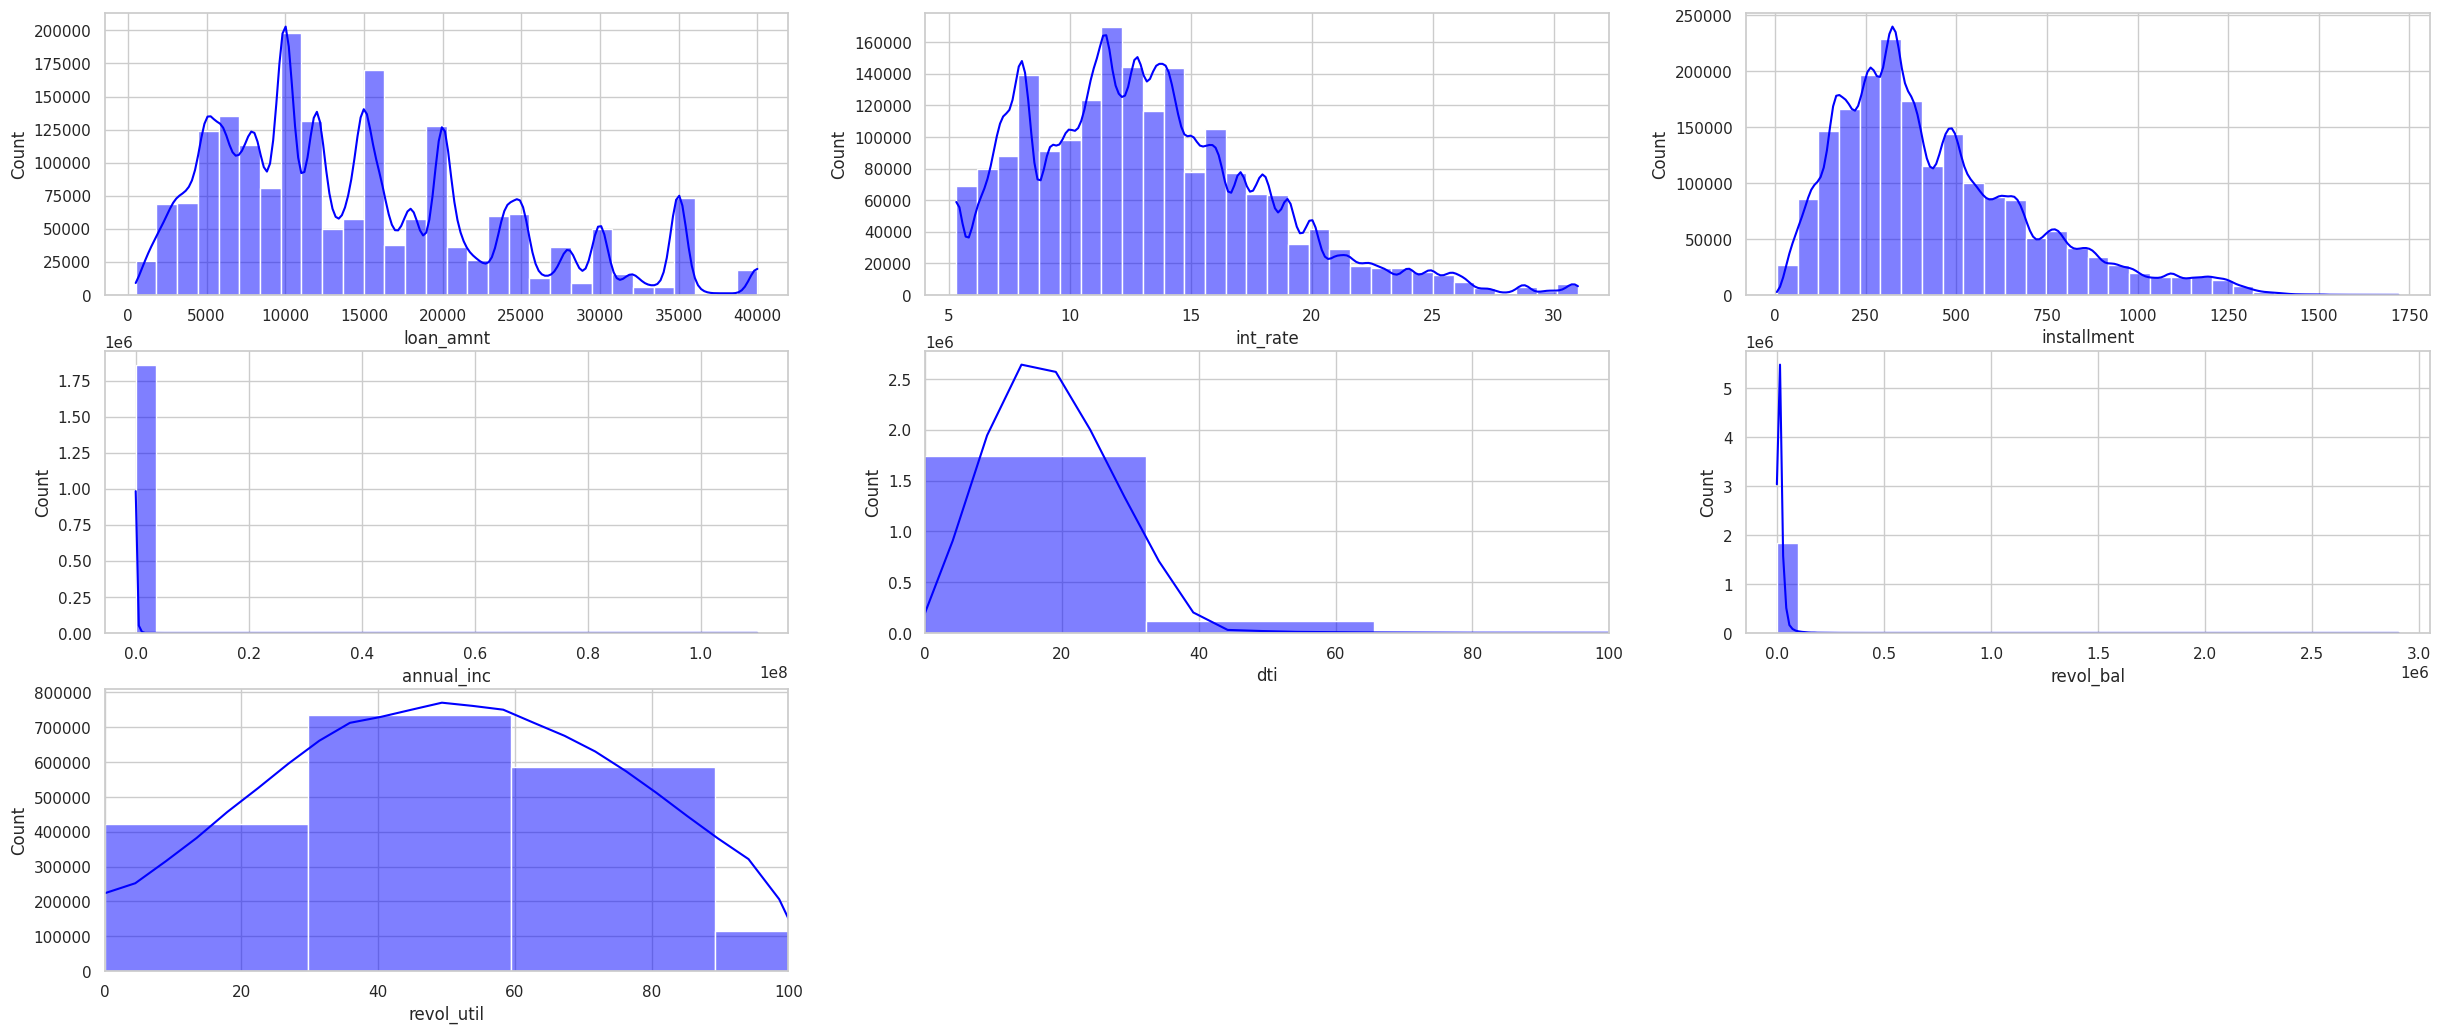

In [69]:
plt.figure(figsize=(30, 30))  # Adjust the figure size as needed
sns.set(style="whitegrid")

plt.subplot(7, 3, 1)
sns.histplot(x='loan_amnt', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 2)
sns.histplot(x='int_rate', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 3)
sns.histplot(x='installment', data=df , bins=30, kde=True, color='blue')

plt.subplot(7, 3, 4)
sns.histplot(x='annual_inc', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 5)
sns.histplot(x='dti', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)


plt.subplot(7, 3, 6)
sns.histplot(x='revol_bal', data=df, bins=30, kde=True, color='blue')

plt.subplot(7, 3, 7)
sns.histplot(x='revol_util', data=df, bins=30, kde=True, color='blue')
plt.xlim(0, 100)

Among all numerical features, there are some feautures whose distributions are skewed, such as `installment`, `int_rate`, `dti`. We would perform some transformation methods to normalize their distributions:

- Box-Cox transformation
- Min-max scaling
- Logarithmic transformation
- Square root transformation

### Intuition
Imagine you have the annual income's feature values ranging from 0 to 300,000. While most of the borrowers earn an annual income around $50,000-$70,000, some of them may earn a lot more, let's say $200,000. So the distribution will be skewed. The same happened to our numerical features. If we apply a Log transformation:

- `log`(200,000) ≈ 5.301
- `log`(60,000) ≈ 4.778

=> Now the values have a much more even scale!

In [70]:
df.select_dtypes(include=[float]).head()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
0,5000.00,10.65,162.87,24000.00,27.65,3.00,0.00,13648.00,83.70,9.00,2.00,0.00
1,2500.00,15.27,59.83,30000.00,1.00,3.00,0.00,1687.00,9.40,4.00,2.00,0.00
2,2400.00,15.96,84.33,12252.00,8.72,2.00,0.00,2956.00,98.50,10.00,2.00,0.00
3,10000.00,13.49,339.31,49200.00,20.00,10.00,0.00,5598.00,21.00,37.00,2.00,0.00
4,3000.00,12.69,67.79,80000.00,17.94,15.00,0.00,27783.00,53.90,38.00,2.00,0.00


However, we observe there exists some values in `pub_rec` and `pub_rec_bankruptcies` which are 0. There might be potential values that are 0 in other columns too. And there is a huge problem with `log`:
- `log`(0) goes to minus infinity

Therefore, Log Transform might not be a good option. We might approach a different method: Square root transformation. However, we should check if any feature column contains negative values, since the square root of a negative number is undefined.
- `loan_amnt`, `installment`, `open_acc`, `pub_rec`, `total_acc`, `mort_acc`, `pub_rec_bankruptcies`: negative values will not make sense for these features.
  - Ex: a person can't have a negative number of mortgage accounts.
- for `int_rate`, `annual_inc`, `dti`, `revol_bal`, `revol_util`, let's check if they contain any negative values.

Fortunately, `open_acc`, `pub_rec`, `total_acc`, `mort_acc`, `pub_rec_bankruptcies` represent the number of mortgage accounts, derogatory public records, etc, so if we normalize these features, some normalized values might be float, which don't make sense as they should be whole numbers. Therefore, we would not consider scaling these features.


In [76]:
print("Interest rate minimum: ", df['int_rate'].min())
print("Annual income minimum: ", df['annual_inc'].min())
print("DTI minimum: ", df['dti'].min())
print("Revolving balance minimum: ", df['revol_bal'].min())
print("Revolving utilization minimum: ", df['revol_util'].min())

Interest rate minimum:  5.31
Annual income minimum:  0.0
DTI minimum:  0.0
Revolving balance minimum:  0.0
Revolving utilization minimum:  0.0


In [78]:
print("Interest rate maximum: ", df['int_rate'].max())
print("Annual income maximum: ", df['annual_inc'].max())
print("DTI maximum: ", df['dti'].max())
print("Revolving balance maximum: ", df['revol_bal'].max())
print("Revolving utilization maximum: ", df['revol_util'].max())

Interest rate maximum:  30.99
Annual income maximum:  110000000.0
DTI maximum:  999.0
Revolving balance maximum:  2904836.0
Revolving utilization maximum:  892.3


### Addressing inappropriate values
- DTI: It is the Debt-to-Income ratio, calculated by: all monthly debt payments / gross monthly income. It does not make sense if a DTI ratio is negative, as a person doesn't have a negative monthly debt payments or negative income. It might have been a typing error, so we will remove all negative values in `dti`.

- Annual income: We observed that the minimum annual income in our data is 0, which means the person has not earned any income over the entire year. It seems risky for the company to lend the loan to someone who earns no income, so we tend to remove records with 0 values in `annual_inc`.

In [79]:
df = df.drop(df[df['dti'] < 0].index)                     # remove all records with a negative DTI ratio

In [80]:
def count_invalid_values(data):
  '''
    Count the number of invalid values (0 or negative)
    in each feature column to our feature scaling methods
  '''
  counts = []
  invalid_data = {}
  for i in data.columns:
    total = (data[i] <= 0).sum()
    invalid_data[i] = total
  return invalid_data

In [81]:
def normalize_features(data):
  '''
    Normalize each numerical feature in our data
  '''
  for i in data.columns:
    if data[i].dtype == float:
      data[i] = np.log(data[i])
  return data

In [ ]:
# df_rescaled = normalize_features(df)
# df_rescaled.head()

In [ ]:
loan_status_counts = df['loan_status'].value_counts()

loan_status_df = pd.DataFrame({
    'Loan Status': loan_status_counts.index,
    'Counts': loan_status_counts.values
})

loan_status_df

,Loan Status,Counts
0,Fully Paid,1497783
1,Charged Off,362548


In [ ]:
df.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860333 entries, 0 to 1860332
Data columns (total 26 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1860331 non-null  float64
 1   term                  1860331 non-null  object 
 2   int_rate              1860331 non-null  float64
 3   installment           1860331 non-null  float64
 4   grade                 1860331 non-null  object 
 5   sub_grade             1860331 non-null  object 
 6   emp_title             1860333 non-null  object 
 7   emp_length            1860333 non-null  object 
 8   home_ownership        1860331 non-null  object 
 9   annual_inc            1860331 non-null  float64
 10  verification_status   1860331 non-null  object 
 11  issue_d               1860331 non-null  object 
 12  loan_status           1860331 non-null  object 
 13  purpose               1860331 non-null  object 
 14  title                 1838925 non-

In [ ]:
fig = px.bar(loan_status_df, x = 'Loan Status', y = 'Counts',
             labels = {'Loan Status': 'Loan Status', 'Count': 'Count'},
             title = 'Loan Status Counts',
             color = 'Loan Status'
             )

fig.show()

In [ ]:
grade_counts = df['grade'].value_counts()

grade_counts = pd.DataFrame({
    'Loan Grade': grade_counts.index,
    'Counts': grade_counts.values
})

grade_counts

,Loan Grade,Counts
0,B,546603
1,C,528107
2,A,346317
3,D,275001
4,E,116500
5,F,37108
6,G,10695


In [ ]:
fig = px.bar(grade_counts, x='Loan Grade', y='Counts',
             labels={'Grade': 'Grade', 'Count': 'Count'},
             title = 'Loan Grade Counts',
             color = 'Loan Grade',
             )
fig.show()

<ipython-input-11-a491a1396c84>:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

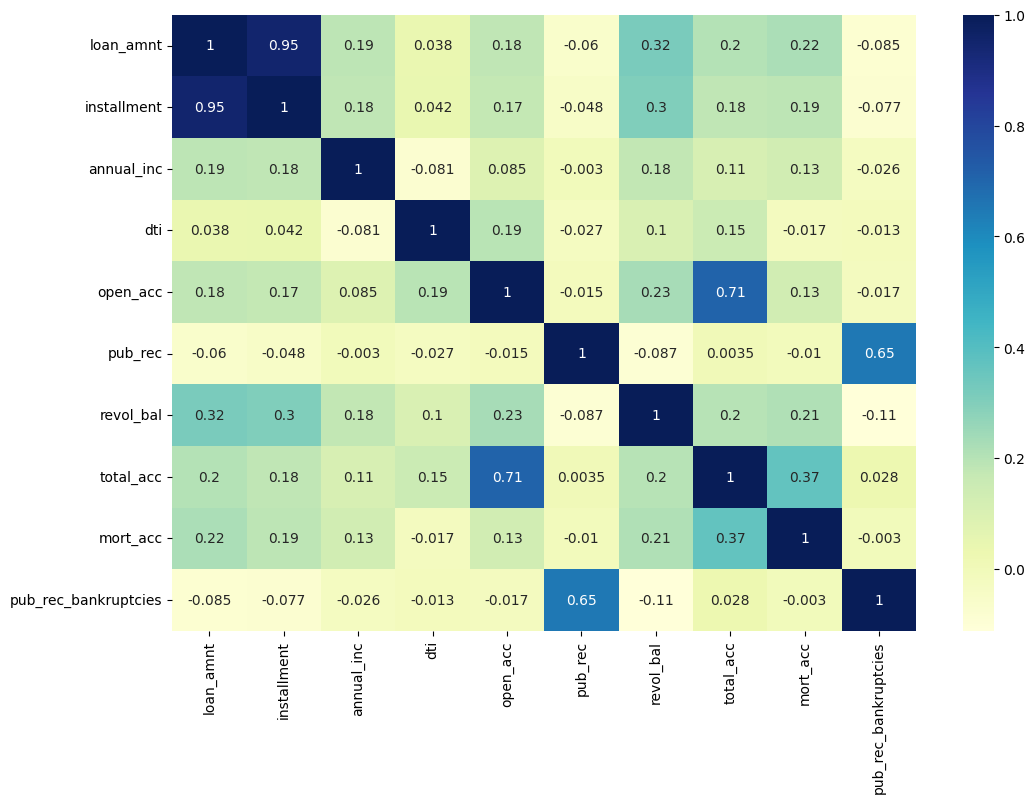

In [ ]:
# correlation between features
plt.figure(figsize=(12, 8))
sb.heatmap(df.corr(), annot = True, cmap = 'YlGnBu')

We observe that loan_amnt and installment have a high correlation to each other, thus we will examine these 2 features to find a way to avoid potential overfitting

In [ ]:
# plot a histogram of installment and loan_amnt, as they have high correlation
# installment_hist = px.histogram(
#     df,
#     x='installment',
#     color='loan_status',
#     marginal='box',
#     nbins=50,
#     opacity=0.4,
#     title="Installment by Loan Status",
#     labels={'installment': 'Installment', 'loan_status': 'Counts'},
# )

# loan_amnt_hist = px.histogram(
#     df,
#     x='loan_amnt',
#     color='loan_status',
#     marginal='box',
#     nbins=30,
#     opacity=0.4,
#     title="Loan amount by Loan Status",
#     labels={'loan_amnt': 'Loan Amount', 'loan_status': 'Counts'},
# )

# installment_hist.show()

<Axes: xlabel='sub_grade', ylabel='count'>

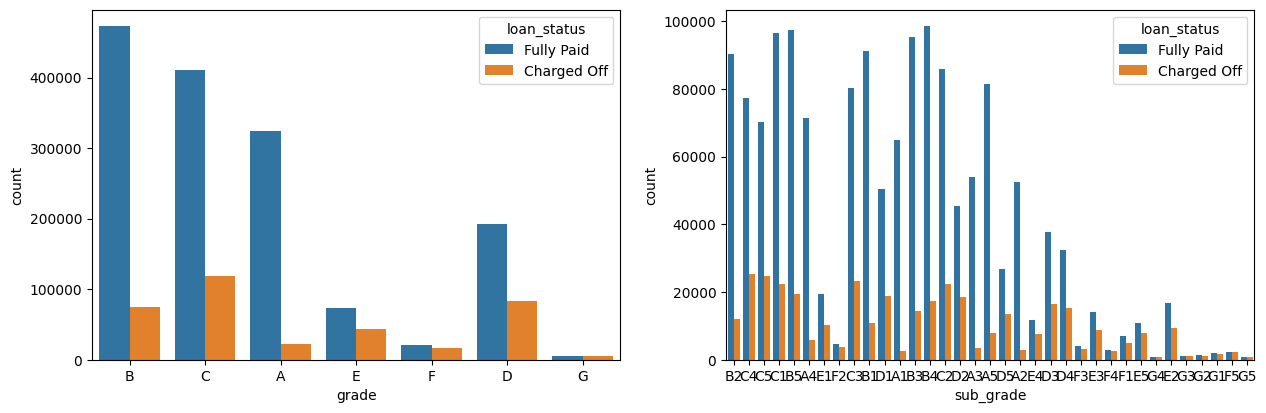

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sb.countplot(data=df, x='grade', hue='loan_status')


plt.subplot(2, 2, 2)
sb.countplot(data=df, x='sub_grade', hue='loan_status')

If we examine the plots, E, F and G loan grades don't get paid oftenly. We look closer into E, F, G specifically

<Axes: xlabel='sub_grade', ylabel='count'>

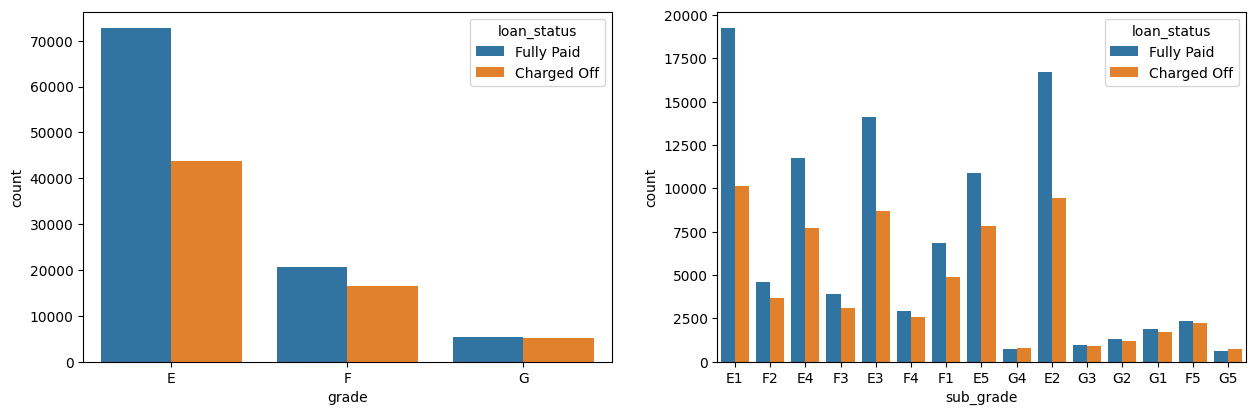

In [ ]:
sub_df = df[(df.grade == 'E') | (df.grade == 'F') | (df.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sb.countplot(data=sub_df, x='grade', hue='loan_status')

plt.subplot(2, 2, 2)
sb.countplot(data=sub_df, x='sub_grade', hue='loan_status')

In [ ]:
df['home_ownership'].value_counts()

MORTGAGE    918028
RENT        735358
OWN         205578
ANY           1174
OTHER          144
NONE            49
Name: home_ownership, dtype: int64

In [ ]:
df.loc[(df.home_ownership == 'NONE') | (df.home_ownership == 'ANY'), 'home_ownership'] = 'OTHER'
df.home_ownership.value_counts()

MORTGAGE    918028
RENT        735358
OWN         205578
OTHER         1367
Name: home_ownership, dtype: int64

[Text(0, 0, 'credit_card'),
 Text(1, 0, 'car'),
 Text(2, 0, 'small_business'),
 Text(3, 0, 'other'),
 Text(4, 0, 'wedding'),
 Text(5, 0, 'debt_consolidation'),
 Text(6, 0, 'home_improvement'),
 Text(7, 0, 'major_purchase'),
 Text(8, 0, 'medical'),
 Text(9, 0, 'moving'),
 Text(10, 0, 'vacation'),
 Text(11, 0, 'house'),
 Text(12, 0, 'renewable_energy'),
 Text(13, 0, 'educational')]

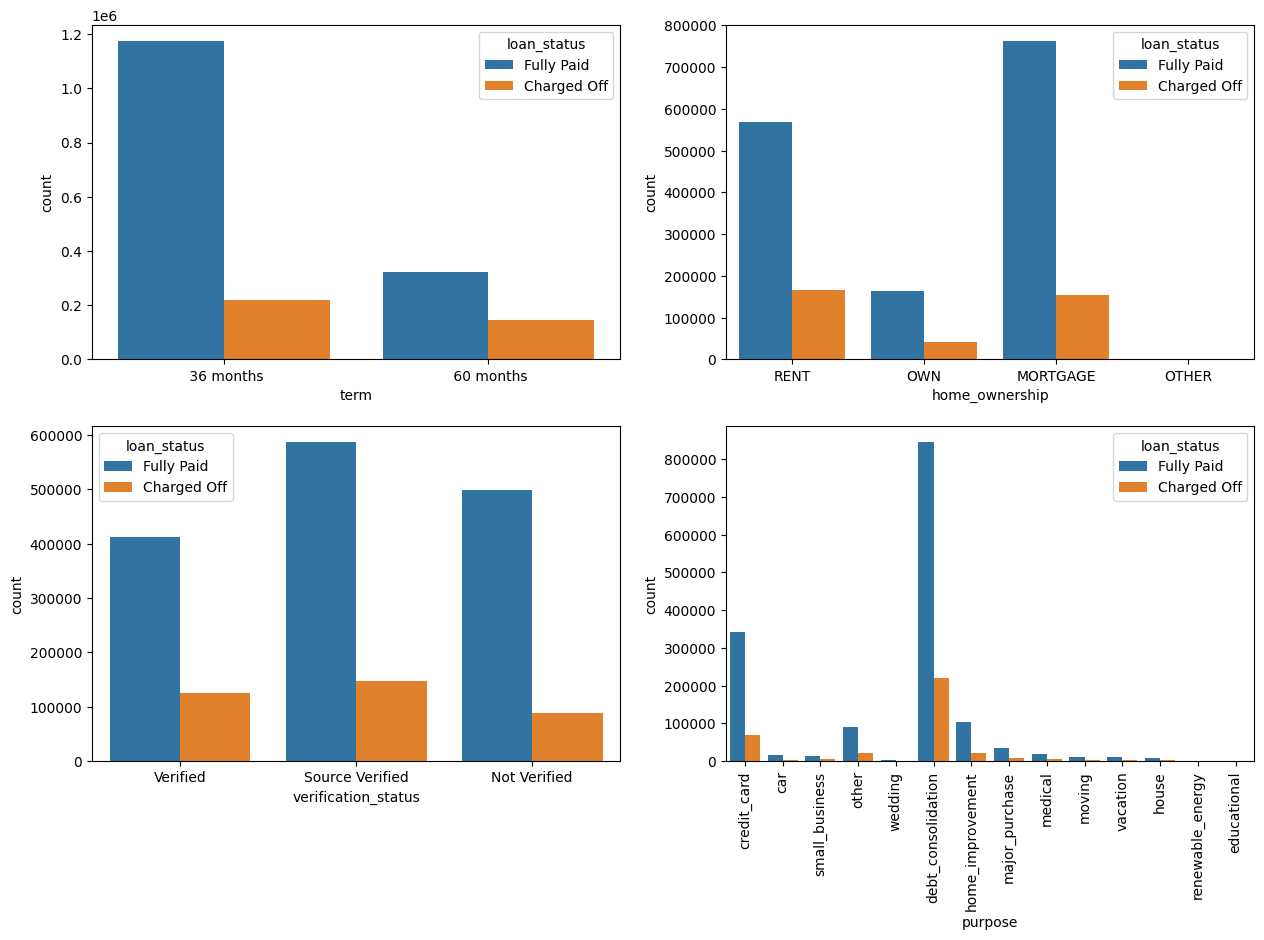

In [ ]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sb.countplot(data=df, x='term', hue='loan_status')

plt.subplot(4, 2, 2)
sb.countplot(data=df, x='home_ownership', hue='loan_status')

plt.subplot(4, 2, 3)
sb.countplot(data=df, x='verification_status', hue='loan_status')

plt.subplot(4, 2, 4)
g = sb.countplot(data=df, x='purpose', hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

- 36-month term seems more likely to be lended to customers and also have higher chance to be fully paid compared to 60-month term
- People who own mortgages have the highest ability to pay off loans, compared to other types
- People with verified status have the highest ability to pay off the loans
- Debt consolidation is the loan purpose with the highest ability to pay off loan debts

In [ ]:
# access the number of fully paid loans and charged off loans in OTHER type of home ownership
df.loc[df['home_ownership']=='OTHER', 'loan_status'].value_counts()

Fully Paid     1094
Charged Off     273
Name: loan_status, dtype: int64

In [ ]:
df['emp_title'].value_counts()[:20]

Teacher               30748
Manager               27960
Owner                 15903
Registered Nurse      12592
RN                    12098
Driver                11682
Supervisor            11664
Sales                 10614
Project Manager        8966
Office Manager         7839
General Manager        7388
Director               7056
owner                  6625
Engineer               6030
President              5949
manager                5943
teacher                5526
Operations Manager     4993
Vice President         4781
driver                 4605
Name: emp_title, dtype: int64

We will use this top 20 employement title to plot a distribution to visualize the amount of fully paid and charged off

In [ ]:
df['emp_title'].value_counts()[:20].index

Index(['Teacher', 'Manager', 'Owner', 'Registered Nurse', 'RN', 'Driver',
       'Supervisor', 'Sales', 'Project Manager', 'Office Manager',
       'General Manager', 'Director', 'owner', 'Engineer', 'President',
       'manager', 'teacher', 'Operations Manager', 'Vice President', 'driver'],
      dtype='object')

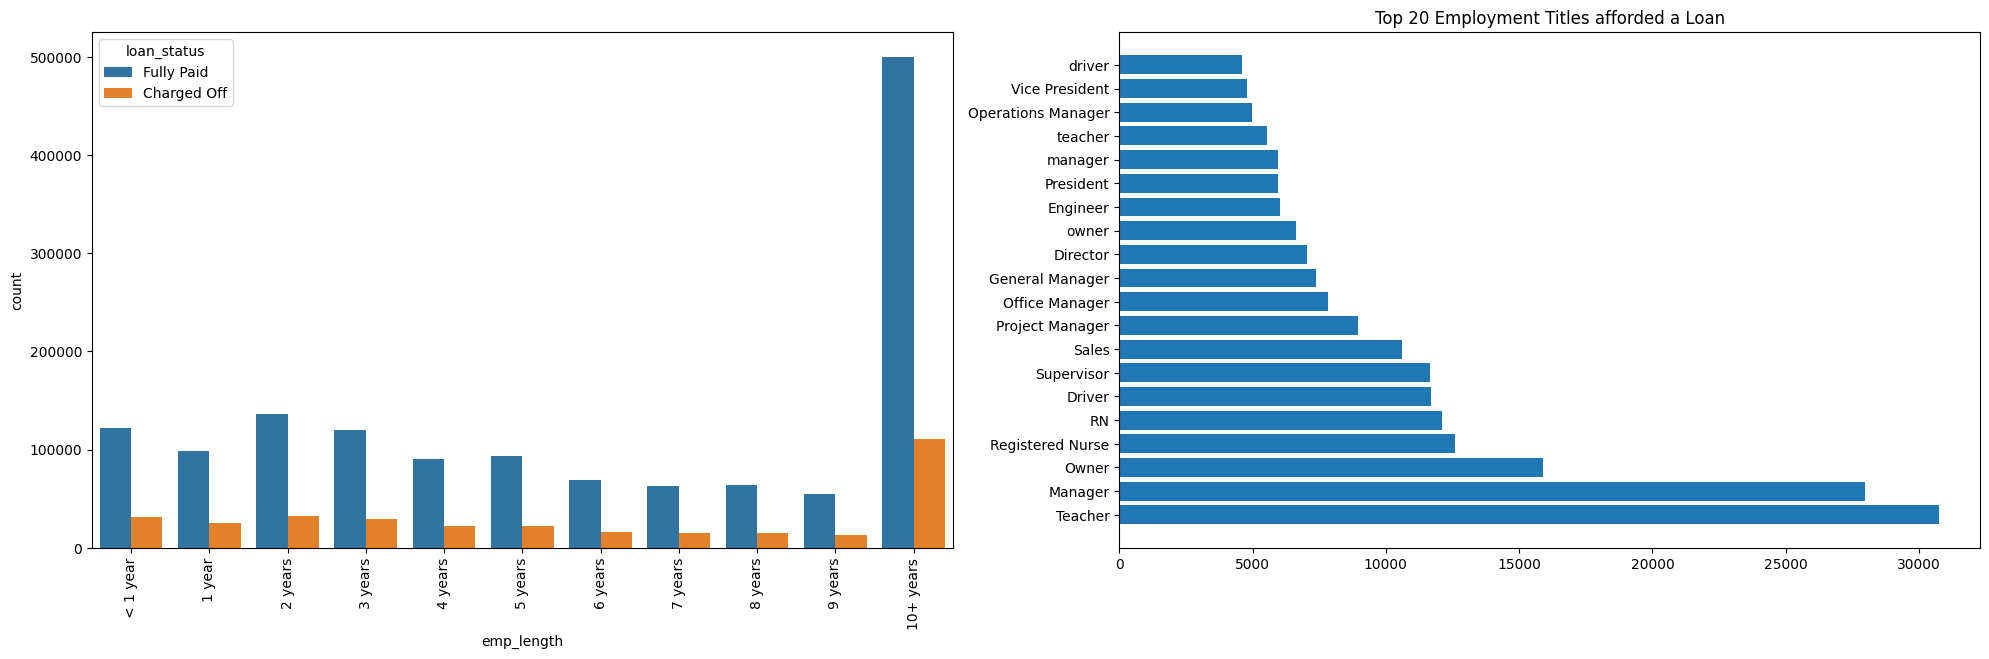

In [ ]:
plt.figure(figsize=(20, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
g = sb.countplot(data=df, x='emp_length', hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.subplot(2, 2, 2)
plt.barh(df['emp_title'].value_counts()[:20].index, df['emp_title'].value_counts()[:20])
plt.title("Top 20 Employment Titles afforded a Loan")
plt.tight_layout()

In [ ]:
df['int_rate'].values

array([' 10.65%', ' 15.27%', ' 15.96%', ..., ' 11.44%', ' 25.49%', nan],
      dtype=object)

We observe that the values in int_rate is of string type, and contain % sign. We would remove that sign and transform values into float type

In [ ]:
df['int_rate'] = df['int_rate'].str.replace('%', '').astype(float)

In [ ]:
# def remove_percent_sign(data):
#   '''
#     Removes percent sign of every value
#     in the feature column int_rate
#   '''
#   new_data = []
#   for value in list(data):
#     if '%' in value:
#       value = value[:value.index('%')]
#       new_data.append(value)
#   return new_data

In [ ]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])

In [ ]:
df['earliest_cr_line'].value_counts()

2003-09-01    12568
2004-09-01    12561
2001-08-01    12170
2002-08-01    12113
2003-08-01    12027
              ...  
1957-09-01        1
1949-06-01        1
1950-10-01        1
1950-05-01        1
1957-08-01        1
Name: earliest_cr_line, Length: 763, dtype: int64

In [ ]:
df['issue_d'].value_counts()

2016-03-01    57553
2015-10-01    45443
2015-07-01    43414
2015-12-01    41306
2014-10-01    38781
              ...  
2007-08-01       33
2008-09-01       32
2007-07-01       30
2007-09-01       18
2007-06-01        1
Name: issue_d, Length: 160, dtype: int64

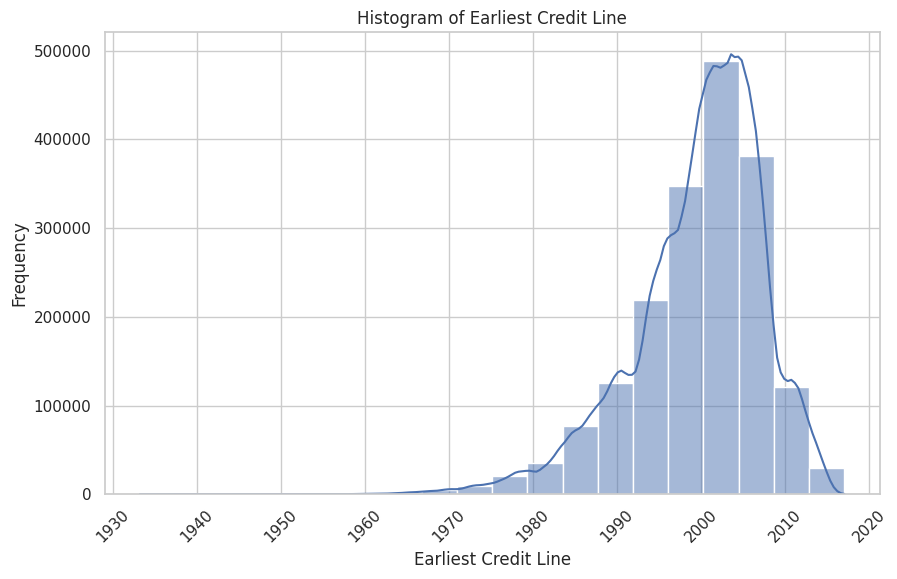

In [ ]:
sb.set(style="whitegrid")

# Create the histogram
plt.figure(figsize=(10, 6))
sb.histplot(data=df, x='earliest_cr_line', bins=20, kde=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Earliest Credit Line')
plt.ylabel('Frequency')
plt.title('Histogram of Earliest Credit Line')

# Show the plot
plt.show()